In [488]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import math


In [489]:
x_length = 1000  # meters
y_length = 1000  # meters
n_aps = 5        # Number of APs
n_users = 10     # Number of users
M_ant = 100          # Antennas per AP
p_p = 0.2        # Pilot power (W)
p_d = 0.2        # Data power (W)
tau_c = 200      # Coherence length (symbols)
tau_p = 20       # Pilot length (symbols)
gamma = 1.76     # Path loss exponent
shadow_std = 5   # Shadow fading standard deviation (dB)
beta_0db = 1.3    # Reference path loss

np.random.seed(42)

In [490]:
x_pos_aps = np.random.uniform(0, x_length, n_aps)
y_pos_aps = np.random.uniform(0, y_length, n_aps)

x_pos_users = np.random.uniform(0, x_length, n_users)
y_pos_users = np.random.uniform(0, y_length, n_users)

X_aps = np.column_stack((x_pos_aps, y_pos_aps))
X_users = np.column_stack((x_pos_users, y_pos_users))

In [491]:
def compute_distances(X_users, X_aps):
    n_users, n_aps = len(X_users), len(X_aps)
    distances = np.zeros((n_users, n_aps))
    for k in range(n_users):
        for l in range(n_aps):
            distances[k, l] = np.sqrt((X_users[k, 0] - X_aps[l, 0])**2 +
                                      (X_users[k, 1] - X_aps[l, 1])**2)
    return distances

In [492]:
def compute_beta(distances, gamma, shadow_std):
    n_users, n_aps = distances.shape
    beta_linear = np.zeros((n_users, n_aps))
    for k in range(n_users):
        for l in range(n_aps):
            d_kl = max(distances[k, l], 1)  # Avoid log(0)
            path_loss = -beta_0db - gamma * np.log10(d_kl)
            shadow_fading = np.random.normal(0, shadow_std)
            beta_dB = path_loss + shadow_fading
            beta_linear[k, l] = 10 ** (beta_dB / 10)
    return beta_linear

# Compute eta_kl
def compute_eta(beta, p_p, tau_p):
    eta = (p_p * tau_p * beta**2) / (tau_p * p_p * beta + 1)
    return eta

In [493]:
def compute_spectral_efficiency(assignment, beta, eta, M_ant, p_d, tau_c, tau_p,eta_kl):

    # M_ant = 100          # Antennas per AP
    # p_p = 0.2        # Pilot power (W)
    # p_d = 0.2        # Data power (W)
    # tau_c = 100      # Coherence length (symbols)
    # tau_p = 10       # Pilot length (symbols)
    # gamma = 3.76     # Path loss exponent
    # shadow_std = 5   # Shadow fading standard deviation (dB)
    # beta_0db = 8.53

    n_users, n_aps = beta.shape
    S = np.zeros(n_users)

    # Users served by each AP
    interference = 0
    U = [[] for _ in range(n_aps)]
    # if(len(assignment)>=n_users):
    for k in range(n_users):
        if(k<len(assignment)):
            l_k = assignment[k]
            U[l_k].append(k)

        for j in range(n_aps):
            for i in U[j]:
                interference += M_ant * p_d * eta[i, j] * beta[k, j]

        

    # for k in range(n_users):
    # l_k = assignment
    # numerator = M_ant**2 * p_d * eta[k, l_k]**2
    numerator = M_ant**2 * p_d * eta_kl**2

    # interference = 0
    # for j in range(n_aps):
    #     for i in U[j]:
    #         interference += M_ant * p_d * eta[i, j] * beta[k, j]
    denominator = interference + 1  # noise normalized to 1

    SINR_k = numerator / denominator
    S = ((tau_c - tau_p) / tau_c) * np.log2(1 + SINR_k)

    return S

In [494]:
def CAPS(n_users,distances,assignments,iter):

    n_clusters = 5
    def clusters():
        kmeans_aps = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
        cluster_labels_aps = kmeans_aps.fit_predict(X_aps)
        # print("cluster_labels_aps: ",cluster_labels_aps)
        clusterAP = [[] for _ in range(n_clusters)]

        for i in range(n_aps):
            clusterAP[cluster_labels_aps[i]].append(i)

        return kmeans_aps.cluster_centers_ , clusterAP

    centroids_aps,clusterAP = clusters()

    def dist_centroid():
        distances = np.zeros((n_users, n_clusters))

    # Calculate distances between each user and each cluster centroid
        for i in range(n_users):
            for j in range(n_clusters):
                # Calculate Euclidean distance in 3D space
                distances[i, j] = np.sqrt(np.sum((X_users[i] - centroids_aps[j])**2))

        # sorted_distances = np.zeros_like(distances)
        # sorted_indices = np.zeros_like(distances, dtype=int)
        clusterX=np.zeros(n_users,dtype=int)
        for i in range(n_users):
            clusterX[i] = np.argsort(distances[i])[0]
        return clusterX
    
    clusterX = dist_centroid()

    def assign_nearest_ap():
        Mi = [[] for _ in range(n_users)]
        for i in range(n_users):
            Mi[i]=clusterAP[clusterX[i]]
        return Mi

    Mi = assign_nearest_ap()
    # print(Mi)
    
    # def calc_dist():
        

    beta = compute_beta(distances, gamma, shadow_std)
    eta = compute_eta(beta, p_p, tau_p)
    # assignments = []

    spectralEff = [[] for _ in range(n_users)]

    for i in range(n_users):
        for j in range(len(Mi[i])):
            S = compute_spectral_efficiency(assignments, beta, eta, M_ant, p_d, tau_c, tau_p,eta[i][j])
            spectralEff[i].append(S)
        # print(max(spectralEff[i]))
    
    # print(spectralEff)
    # print("\n\n")
# 
    # for i in range(n_users):
    #     argmax = np.argmax(spectralEff[i])
    #     if(i>=len(assignments)):
    #         assignments.append(argmax)
    #     else:
    #         [i] = argmax
    argm = np.argmax(spectralEff[iter])

    assignments[iter]=Mi[iter][argm]
    # print(assignments)
    # print(spectralEff)

    return spectralEff
    
    # return assignments
    # for i in range(n_users):
    #     for j in range(len(Mi[i])):
    #         S = compute_spectral_efficiency(assignments, beta, eta, M_ant, p_d, tau_c, tau_p,eta[i][j])
    #         spectralEff[i]


In [495]:
assignments = [0 for _ in range(n_users)]
distances = compute_distances(X_users,X_aps)
iter = 0

In [496]:

# while(iter<n_users):
#         # print(f'this is iteration {iter}')
#         spectralEff = CAPS(n_users,distances,assignments,iter)
#         iter+=1

In [497]:
n_realizations=500
sum_se=[]

for i in range(n_realizations):
    iter=0
    while(iter<n_users):
        # print(f'this is iteration {iter}')
        spectralEff = CAPS(n_users,distances,assignments,iter)
        iter+=1
    print(i)
    eff=[]
    for j in range(len(spectralEff)):
        eff.append(max(spectralEff[j]))
    sum_se.append(np.sum(eff))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [498]:
for k in range(n_users):
    print(f"User {k} assigned to AP {assignments[k]}: SE = {spectralEff[k]}")

User 0 assigned to AP 4: SE = [np.float64(0.007483021973982211)]
User 1 assigned to AP 1: SE = [np.float64(0.14883935837154785)]
User 2 assigned to AP 1: SE = [np.float64(0.08328290993163823)]
User 3 assigned to AP 0: SE = [np.float64(0.07005583758758333)]
User 4 assigned to AP 4: SE = [np.float64(1.5105234777887688)]
User 5 assigned to AP 4: SE = [np.float64(2.0019259625142865)]
User 6 assigned to AP 0: SE = [np.float64(0.5652191933905327)]
User 7 assigned to AP 3: SE = [np.float64(4.291697570645085)]
User 8 assigned to AP 3: SE = [np.float64(0.0012142119798149297)]
User 9 assigned to AP 0: SE = [np.float64(8.21525542426242e-05)]


Sum SE values across realizations:


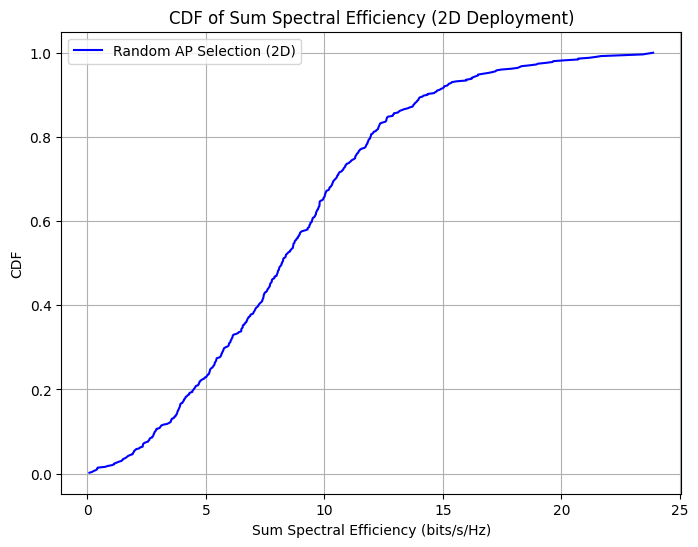

In [499]:
print("Sum SE values across realizations:")
# print(sum_se)
sum_se = np.sort(sum_se)
cdf = np.arange(1, len(sum_se) + 1) / len(sum_se)

# Plot CDF
plt.figure(figsize=(8, 6))
plt.plot(sum_se, cdf, 'b-', label='Random AP Selection (2D)')
# plt.xlim([0, 30])
plt.title('CDF of Sum Spectral Efficiency (2D Deployment)')
plt.xlabel('Sum Spectral Efficiency (bits/s/Hz)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.show()